## Setting Up Your Python Environment

In [1]:
# %conda install cuda -c nvidia/label/cuda-12.1.0 -y
# %conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia/label/cuda-12.1.0 -y
# %pip install -q wurlitzer ninja
# %pip install -q pandas pillow

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
import os, math, gzip, pickle
from urllib.request import urlretrieve
from pathlib import Path

# Import the pandas package
import pandas as pd

# Do not truncate the contents of cells and display all rows and columns
pd.set_option('max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

# Import PIL for image manipulation
from PIL import Image

# Import PyTorch dependencies
import torch
from torch import tensor
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
from torch.utils.cpp_extension import load_inline, CUDA_HOME

# Verify the CUDA install path 
print(CUDA_HOME)

/home/innom-dt/mambaforge/envs/cuda-env


## Setting Up the Project

### Capture C++ Output

In [3]:
# Enable capture of C/C++ output in the notebook cells.
%load_ext wurlitzer

### Make CUDA Operations Synchronous

In [4]:
# Set environment variable to make CUDA operations synchronous for easier debugging
os.environ['CUDA_LAUNCH_BLOCKING']='1'

## Converting RGB Images to Greyscale in Python

### Download a Test Image

In [5]:
# Define the URL of the test image
test_img_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'

# Extract the file name from the URL
test_img_name = Path(test_img_url).name

# Create a Path object for the image file
path_img = Path(test_img_name)

# Check if the image file does not exist in the local directory
if not path_img.exists():
    # If the file does not exist, download it from the URL to the local directory
    urlretrieve(test_img_url, path_img)

### Load the Test Image

In [6]:
img_tensor = io.read_image(str(path_img))
print(img_tensor.shape)

torch.Size([3, 1014, 1280])


In [7]:
resized_img_tensor = tvf.resize(img_tensor, 512, antialias=True)
resized_img_tensor.shape

torch.Size([3, 512, 646])

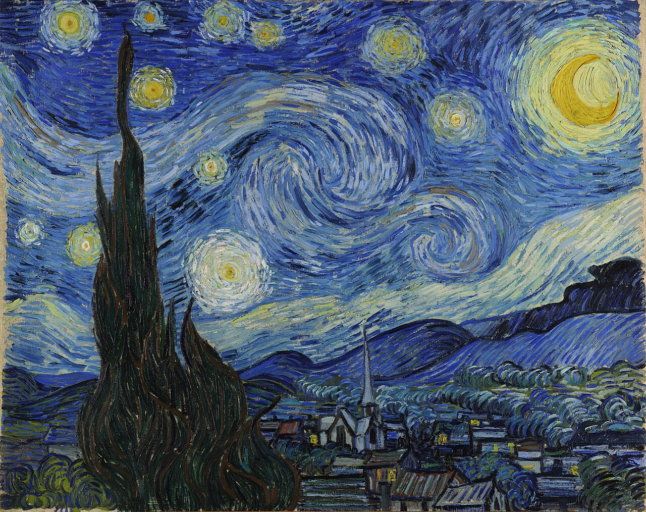

In [8]:
Image.fromarray(resized_img_tensor.permute(1, 2, 0).numpy())

#### Define a function to convert an RGB Tensor to Greyscale

In [9]:
def rgb2grey_py(rgb_tensor):
    # Extract the channel (c), height (h), and width (w) dimensions of the input image tensor
    c, h, w = rgb_tensor.shape
    # Calculate the total number of pixels in the image (height * width)
    n = h * w
    # Flatten the input image tensor from CxHxW format to a long array to simplify processing
    rgb_tensor = rgb_tensor.flatten()
    # Create an empty tensor 'res' to hold the grayscale values, with the same datatype and device as the input
    res = torch.empty(n, dtype=rgb_tensor.dtype, device=rgb_tensor.device)
    
    # Loop through each pixel to compute the grayscale value
    for i in range(n):
        # Apply the grayscale conversion formula: 0.2989 * Red + 0.5870 * Green + 0.1140 * Blue
        res[i] = 0.2989 * rgb_tensor[i] + 0.5870 * rgb_tensor[i+n] + 0.1140 * rgb_tensor[i+2*n]
    
    # Reshape the resulting flat grayscale values back into a 2D image (height x width)
    return res.view(h, w)

#### Time the Python implementation

In [10]:
%%time
img_grey_tensor = rgb2grey_py(resized_img_tensor)

CPU times: user 7.54 s, sys: 11.1 ms, total: 7.55 s
Wall time: 6.64 s


#### Verify the Result

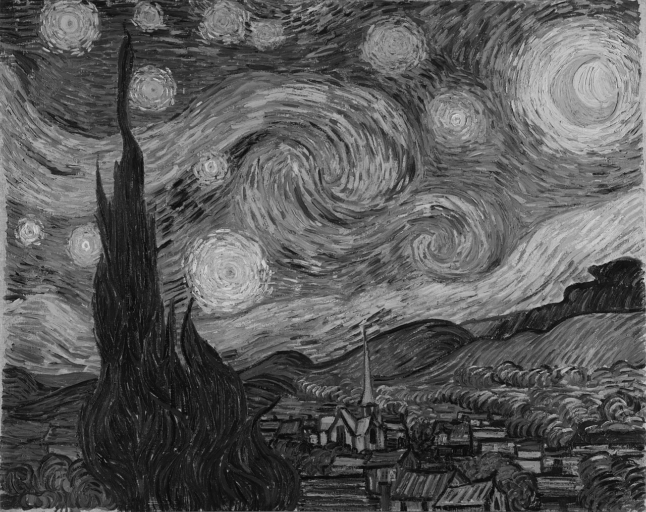

In [11]:
Image.fromarray(img_grey_tensor.numpy(), mode='L')

## Converting RGB Images to Greyscale in CUDA

### Define the CUDA Code

#### Define the utility includes and definitions for PyTorch and CUDA

In [12]:
cuda_utils_macros = r'''
// Include the necessary headers for PyTorch and CUDA functionality.
#include <torch/extension.h> // PyTorch extension library for custom C++ and CUDA extensions.
#include <stdio.h> // Standard I/O for debugging (e.g., printf).
#include <c10/cuda/CUDAException.h> // CUDA-specific exceptions for error handling.

// Macro to check if a tensor is allocated on a CUDA device.
// If not, it throws an error.
// x: The tensor to check.
#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")

// Macro to check if a tensor is contiguous in memory.
// If not, it throws an error.
// Contiguous tensors are often required for efficient CUDA operations.
// x: The tensor to check.
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")

// Macro to perform both CUDA and contiguity checks on a tensor.
// This is a convenience macro to ensure a tensor is suitable for CUDA operations.
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

// Function to calculate the ceiling of an integer division.
// This is often used to determine the number of blocks needed in a CUDA kernel launch
// when the total number of threads does not evenly divide by the number of threads per block.
// a: The numerator in the division.
// b: The denominator in the division.
// Returns: The smallest integer greater than or equal to a/b.
inline unsigned int cdiv(unsigned int a, unsigned int b) { 
    return (a + b - 1) / b;
}
'''

#### Define the CUDA kernel for RGB to Grayscale conversion

- 2^31 max blocks for dim 0, 2^16 max for dims 1 & 2
- 1024 max threads per block (use a multiple of 32)

In [13]:
cuda_kernel = r'''
// CUDA kernel to convert an RGB image to grayscale.
// Inputs:
// - x: Pointer to the input image data in RGB format.
// - out: Pointer to the output image data in grayscale.
// - n: The total number of pixels in the image.
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    // Calculate the global thread index.
    int i = blockIdx.x * blockDim.x + threadIdx.x;

    // Ensure the thread index is within the bounds of the image data.
    if (i < n) {
        // Convert the RGB values to grayscale using the luminosity method.
        // The luminosity method is a weighted sum of the R, G, and B values.
        // Weights: 0.2989 for Red, 0.5870 for Green, and 0.1140 for Blue.
        out[i] = 0.2989 * x[i] + 0.5870 * x[i + n] + 0.1140 * x[i + 2 * n];
    }
}
'''

#### Define the PyTorch function to convert RGB to Grayscale

In [14]:
pytorch_function = r'''
// Function to convert a PyTorch tensor representing an RGB image to grayscale.
// Input:
// - input: A PyTorch tensor of the input RGB image.
// Output:
// - A PyTorch tensor of the output grayscale image.
torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    // Check that the input tensor is of the correct format, device, etc.
    CHECK_INPUT(input);
    
    // Extract the height and width from the input tensor's dimensions.
    int h = input.size(1);
    int w = input.size(2);
    printf("h*w: %d*%d\n", h, w); // Debug print statement for dimensions.

    // Create an empty output tensor with the same dimensions as the input.
    auto output = torch::empty({h, w}, input.options());

    // Define the number of threads per block.
    int threads = 256;
    
    // Calculate the number of blocks needed for the conversion, ensuring
    // we have enough blocks to cover all pixels.
    // Launch the CUDA kernel with calculated dimensions.
    rgb_to_grayscale_kernel<<<cdiv(w*h, threads), threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);

    // Check for any errors during kernel launch or execution.
    C10_CUDA_KERNEL_LAUNCH_CHECK();

    // Return the output tensor.
    return output;
}
'''

### Build the PyTorch Extension

In [15]:
# Combine the CUDA source code
cuda_src = cuda_utils_macros + cuda_kernel + pytorch_function
# Define the C++ source code
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

# A flag indicating whether to use optimization flags for CUDA compilation.
opt=False

# Compile and load the CUDA and C++ sources as an inline PyTorch extension
module = load_inline(
    cuda_sources=[cuda_src],                  # List of CUDA source code strings.
    cpp_sources=[cpp_src],                    # List of C++ source code strings.
    functions=['rgb_to_grayscale'],           # List of function names to be included in the extension.
    extra_cuda_cflags=["-O2"] if opt else [], # Enable optimization flags if `opt` is True.
    verbose=True,                             # Enable verbose output if `verbose` is True.
    name="inline_ext"                         # Name of the generated extension module.
)

Using /home/innom-dt/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/innom-dt/.cache/torch_extensions/py311_cu121/inline_ext/build.ninja...
Building extension module inline_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/innom-dt/mambaforge/envs/cuda-env/lib/python3.11/site-packages/torch/include -isystem /home/innom-dt/mambaforge/envs/cuda-env/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /home/innom-dt/mambaforge/envs/cuda-env/lib/python3.11/site-packages/torch/include/TH -isystem /home/innom-dt/mambaforge/envs/cuda-env/lib/python3.11/site-packages/torch/include/THC -isystem /home/innom-dt/mambaforge/envs/cuda-env/include -isystem /home/innom-dt/mambaforge/envs/cuda-env/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /home/innom-dt/.cache/torch_extensions/py311_cu121/inline_ext/main.cpp -o main.o 
[2/3] /home/innom-dt/mambaforge/envs/cuda-env/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=i

Loading extension module inline_ext...


### Getting Information About the Module

#### Get the module path

In [16]:
# Print the path to the extension module
print(f"Module Path: {module.__file__}")

Module Path: /home/innom-dt/.cache/torch_extensions/py311_cu121/inline_ext/inline_ext.so


#### Get the module content

In [34]:
# Print the content of the module folder as a Pandas DataFrame
pd.DataFrame(Path(module.__file__).parent.iterdir())

,0
0,/home/innom-dt/.cache/torch_extensions/py311_cu121/inline_ext/inline_ext.so
1,/home/innom-dt/.cache/torch_extensions/py311_cu121/inline_ext/cuda.cu
2,/home/innom-dt/.cache/torch_extensions/py311_cu121/inline_ext/.ninja_deps
3,/home/innom-dt/.cache/torch_extensions/py311_cu121/inline_ext/main.cpp
4,/home/innom-dt/.cache/torch_extensions/py311_cu121/inline_ext/build.ninja
5,/home/innom-dt/.cache/torch_extensions/py311_cu121/inline_ext/.ninja_log
6,/home/innom-dt/.cache/torch_extensions/py311_cu121/inline_ext/main.o
7,/home/innom-dt/.cache/torch_extensions/py311_cu121/inline_ext/cuda.cuda.o


#### Get the module attributes

In [18]:
# Print the attribute names of the module as a Pandas DataFrame
pd.DataFrame(dir(module))

,0
0,__doc__
1,__file__
2,__loader__
3,__name__
4,__package__
5,__spec__
6,rgb_to_grayscale


### Test the PyTorch Extension

#### Prepare the image tensor

In [19]:
# Convert the tensor to a contiguous format and move it to the default CUDA device
img_tensor_cuda = resized_img_tensor.contiguous().cuda()

#### Time the CUDA implementation

In [20]:
%%time
res = module.rgb_to_grayscale(img_tensor_cuda).cpu()
h,w = res.shape
h,w,h*w

CPU times: user 869 µs, sys: 0 ns, total: 869 µs
Wall time: 1.08 ms


(512, 646, 330752)

h*w: 512*646


#### Verify the Result

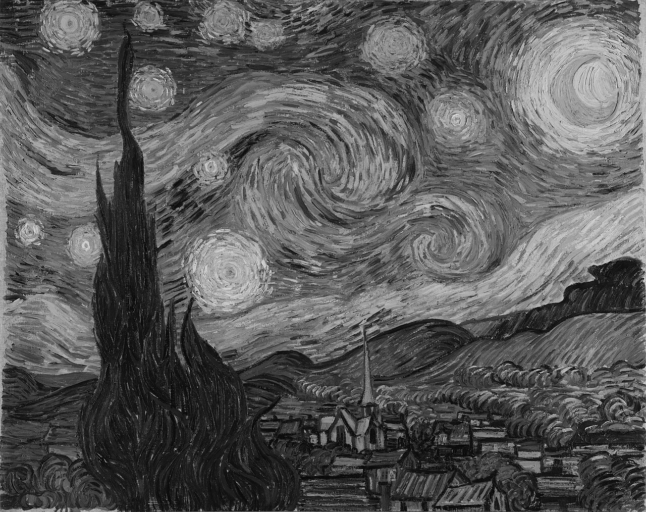

In [21]:
Image.fromarray(res.numpy(), mode='L')